<div style="direction:rtl;text-align:right;font-family:Tahoma">
اگر روی گوگل کولب اجرا میکنید این خطوط را از حالت کامنت خارج نمائید.
</div>

In [1]:
!wget https://raw.githubusercontent.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/master/dataset.py
!wget https://raw.githubusercontent.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/master/dataset/Data_hoda_full.mat -P dataset

--2023-12-02 15:07:39--  https://raw.githubusercontent.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/master/dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 917 [text/plain]
Saving to: ‘dataset.py’

dataset.py          100%[===================>]     917  --.-KB/s    in 0s      

2023-12-02 15:07:39 (52.2 MB/s) - ‘dataset.py’ saved [917/917]

--2023-12-02 15:07:40--  https://raw.githubusercontent.com/Alireza-Akhavan/deeplearning-tensorflow2-notebooks/master/dataset/Data_hoda_full.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response

In [2]:
!pip install onnx==1.14.1.
!pip install tf2onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.5 MB/s eta 0:00:00


In [14]:
# 1. Import libraries and modules
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
from dataset import load_hoda
import matplotlib.pyplot as plt

In [4]:
# Load pre-shuffled HODA data into train and test sets
X_train, y_train, X_test, y_test = load_hoda(
                                            training_sample_size=5500,
                                            test_sample_size=400,size=28)

In [5]:
# Reshape to original image shape (n x 784)  ==> (n x 28 x 28 x 1)
X_train = X_train.reshape(-1,28,28,1).astype('float32')
X_test = X_test.reshape(-1,28,28,1).astype('float32')

In [6]:

# Define residual block
def residual_block(x, filters):
    y = layers.Conv2D(filters, (3, 3), padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, (3, 3), padding='same')(y)
    y = layers.BatchNormalization()(y)

    # Add the residual connection
    y = layers.add([x, y])
    y = layers.Activation('relu')(y)

    return y

# Define model architecture with residual connections
inp = keras.Input(shape=(28,28,1))
x = layers.Rescaling(1./127.5, offset=-1)(inp)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Add first residual block
x = residual_block(x, filters=32)

x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Add second residual block
x = residual_block(x, filters=64)

x = layers.BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inp, out)

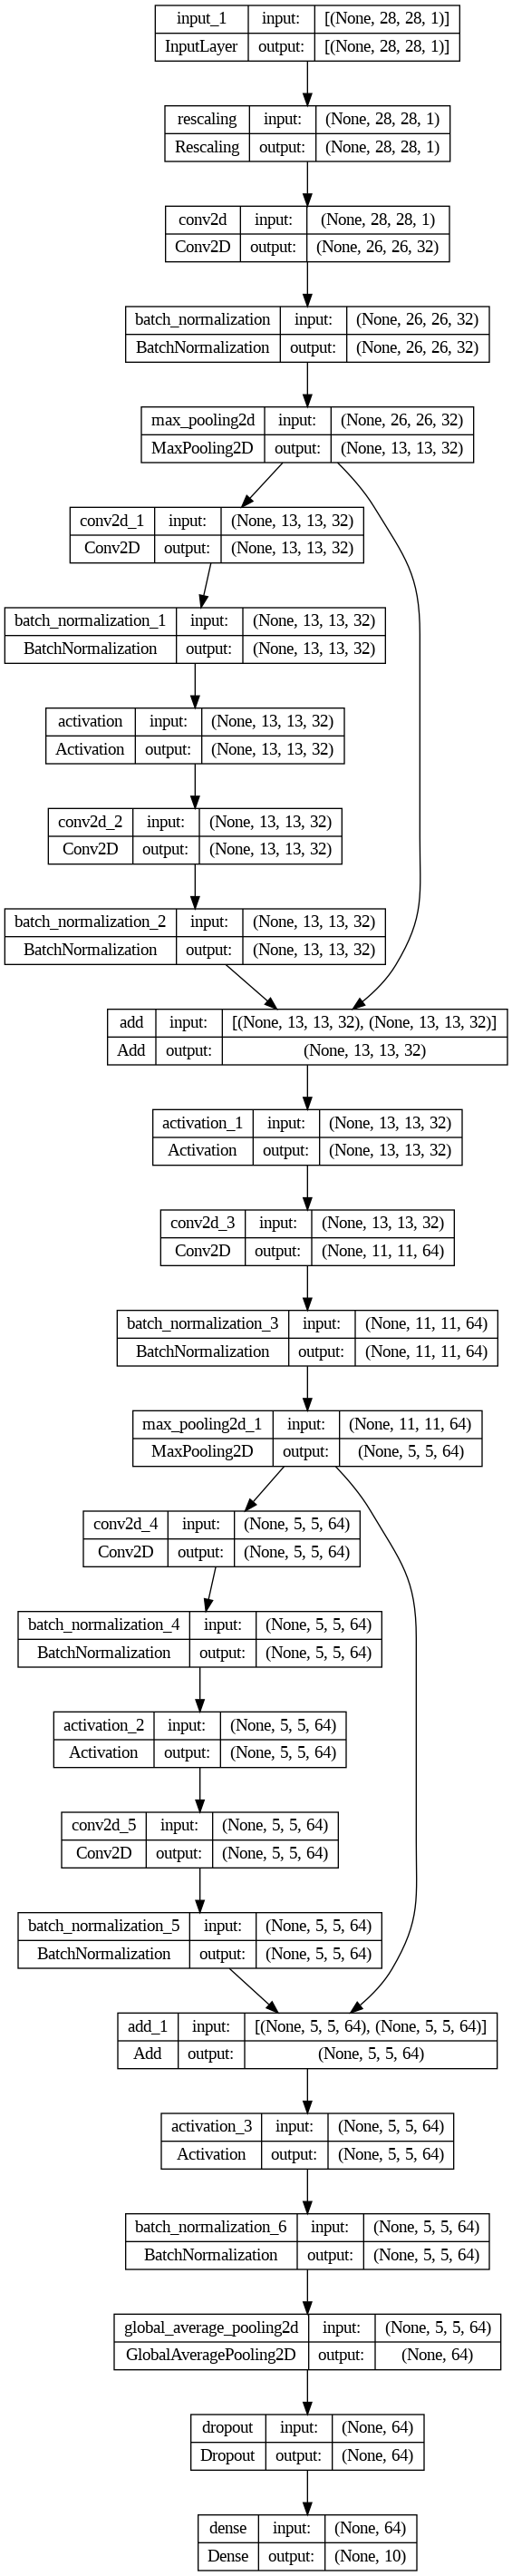

In [7]:
keras.utils.plot_model(model, show_shapes=True)

In [8]:
early_stopping_patience = 30
reduce_lr_patience=10

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=early_stopping_patience, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=reduce_lr_patience)

# 6. Compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# 7. Fit model on training data
history = model.fit(X_train, y_train,
          epochs=100, batch_size=256, validation_split=0.1,
          callbacks=[early_stopping, reduce_lr])

Epoch 1/100
20/20 [==============================] - 18s 51ms/step - loss: 1.1530 - accuracy: 0.6956 - val_loss: 2.0021 - val_accuracy: 0.5782 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 0s 16ms/step - loss: 0.3748 - accuracy: 0.9218 - val_loss: 2.1812 - val_accuracy: 0.1218 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 0s 16ms/step - loss: 0.2067 - accuracy: 0.9596 - val_loss: 2.6175 - val_accuracy: 0.1182 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 0.1373 - accuracy: 0.9715 - val_loss: 2.8976 - val_accuracy: 0.1182 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0990 - accuracy: 0.9828 - val_loss: 3.6635 - val_accuracy: 0.1182 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 0s 16ms/step - loss: 0.0808 - accuracy: 0.9832 - val_loss: 4.0595 - val_accuracy: 0.1182 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 0s 16ms/step - l

In [9]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 0s 13ms/step - loss: 0.0474 - accuracy: 0.9825


[0.04735103249549866, 0.9825000166893005]

## Save TF/Keras model

In [10]:
model.save('persian_number_recognizer.keras')

## Reload model

In [11]:
model = keras.models.load_model('persian_number_recognizer.keras')

In [12]:
keras_prediction = model.predict(X_test)

13/13 [==============================] - 0s 4ms/step


## Convert to ONNX using the Python API

In [18]:
import tf2onnx
import onnxruntime as rt
import tensorflow as tf

spec = (tf.TensorSpec((None, 28, 28, 1), tf.float32, name="input"),)

model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path="export.onnx")
output_names = [n.name for n in model_proto.graph.output]

## Run the ONNX model

In [19]:
providers = ['CPUExecutionProvider']
m = rt.InferenceSession('export.onnx', providers=providers)

In [20]:
onnx_prediction = m.run(output_names, {"input": X_test})

## Keras Vs Onnx comparison

In [22]:
# make sure ONNX and keras have the same results
np.testing.assert_allclose(keras_prediction, onnx_prediction[0], rtol=1e-4)

In [23]:
%timeit model.predict(X_test, verbose=0)

181 ms ± 49.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit m.run(output_names, {"input": X_test})

235 ms ± 20.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
